In [21]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

points=100

In [27]:
import numpy as np
from scipy.fft import fft, fftfreq

def find_dominant_frequencies(data, sampling_rate=100):
    """
    Find the dominant frequency for each sine wave in the input data.
    
    Parameters:
    data (numpy.ndarray): 2D array of shape (n_waves, n_samples)
    sampling_rate (float): The sampling rate of the sine waves
    
    Returns:
    numpy.ndarray: 1D array of dominant frequencies for each sine wave
    """
    n_waves, n_samples = data.shape
    
    # Compute the FFT for each row
    fft_results = np.abs(fft(data, axis=1))
    
    # Create frequency axis
    frequencies = fftfreq(n_samples, 1 / sampling_rate)
    
    # We only need the positive frequencies
    positive_freq_mask = frequencies > 0
    positive_frequencies = frequencies[positive_freq_mask]
    fft_results = fft_results[:, positive_freq_mask]
    
    # Find the dominant frequency for each sine wave
    dominant_frequencies = positive_frequencies[np.argmax(fft_results, axis=1)]
    
    return dominant_frequencies




In [32]:
def make_sine(amp=1, freq=1, phase=0, offset=0.5, points=100, samples=1):
    x = np.linspace(0, 10, points)
    sine = amp * np.sin(2 * np.pi * freq * x + phase) + offset
    return sine

def make_real(amp=1, freq=1, phase=0, offset=0.5, points=100, samples=1, noise=0.1):
    sine = make_sine(amp=amp, freq=freq, phase=phase, offset=offset, points=100, samples=1)
    return sine + np.random.normal(0, noise, size=len(sine))

#Make loads of sine waves
def make_sine_array(n_waves=100, min_freq=1, max_freq=10, min_amp=0.5, max_amp=1.5, points=100, noise=0.1):
    sine_array = np.zeros((n_waves, points))
    for i in range(n_waves):
        """
        freq = np.random.uniform(min_freq, max_freq)
        amp = np.random.uniform(min_amp, max_amp)
        phase = np.random.uniform(0, 2*np.pi)
        offset = np.random.uniform(-0.5, 0.5)"""
        sine_array[i] = make_real()
    return sine_array

sines = make_sine_array(noise=1)
print (sines.shape)

(100, 100)


(100,)
First 5 dominant frequencies: [1. 1. 1. 1. 1.]


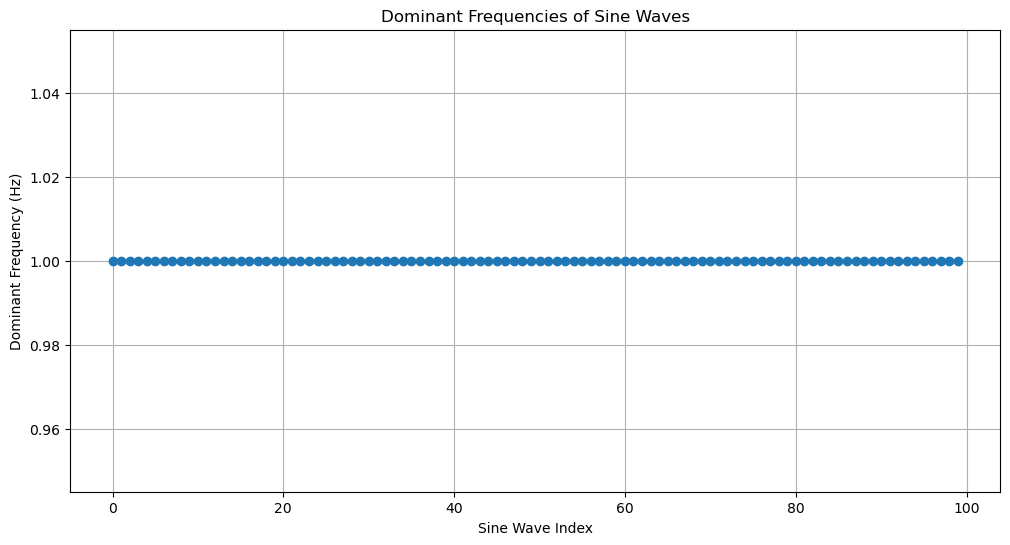

In [33]:
# Find dominant frequencies
dominant_freqs = find_dominant_frequencies(sines, sampling_rate=10)  # Assuming 10 Hz sampling rate

print(dominant_freqs.shape)  # Should print (100,)
print("First 5 dominant frequencies:", dominant_freqs[:5])

# Optional: Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dominant_freqs, 'o')
plt.xlabel('Sine Wave Index')
plt.ylabel('Dominant Frequency (Hz)')
plt.title('Dominant Frequencies of Sine Waves')
plt.grid(True)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [amplitude, frequency, phase, offset, sigma]


Sampling 4 chains for 600 tune and 1_000 draw iterations (2_400 + 4_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


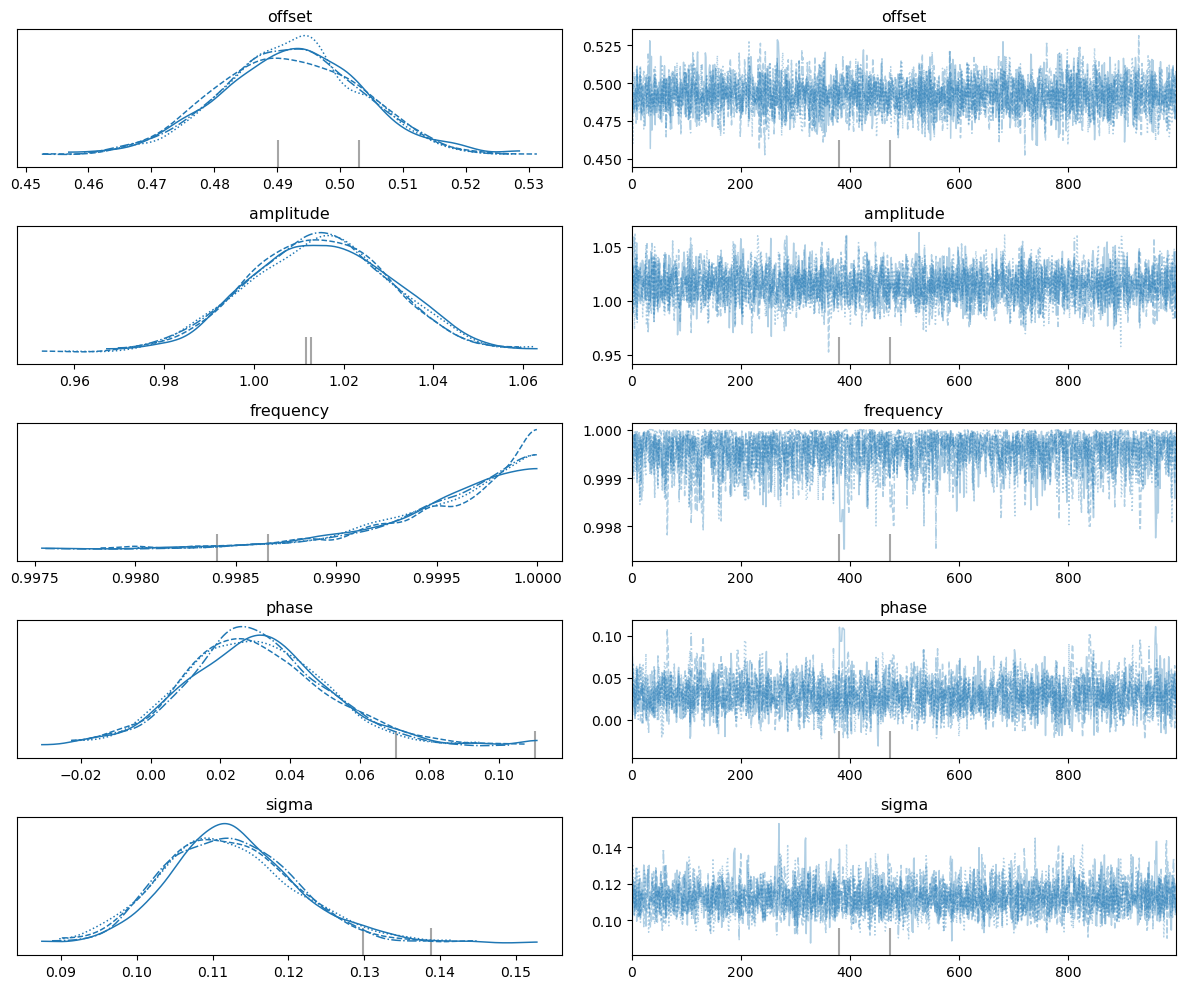

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
amplitude  1.015  0.016   0.985    1.043        0.0      0.0    3525.0   
frequency  1.000  0.000   0.999    1.000        0.0      0.0    1479.0   
phase      0.030  0.020  -0.005    0.071        0.0      0.0    2264.0   
offset     0.492  0.011   0.472    0.514        0.0      0.0    3714.0   
sigma      0.112  0.008   0.097    0.128        0.0      0.0    3225.0   

           ess_tail  r_hat  
amplitude    2673.0    1.0  
frequency    1259.0    1.0  
phase        1570.0    1.0  
offset       2905.0    1.0  
sigma        2309.0    1.0  


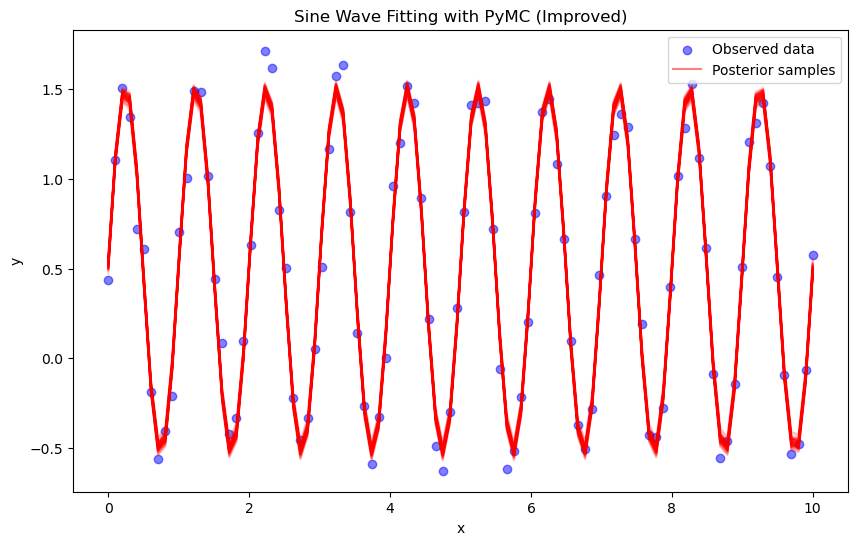

NameError: name 'true_amplitude' is not defined

In [24]:

real_data = make_real(amp=1, freq=1, phase=0, offset=0.5, points=points, samples=1, noise=0.1)

# Define the PyMC model
with pm.Model() as model:
    # Priors
    amplitude = pm.Uniform("amplitude", lower=0, upper=10)
    frequency = pm.Uniform("frequency", lower=0, upper=1)
    phase = pm.Uniform("phase", lower=-np.pi, upper=np.pi)
    offset = pm.Normal("offset", mu=0, sigma=2)
    
    # Add a noise parameter
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=make_sine(amp=amplitude, freq=frequency, phase=phase, offset=offset), 
                      sigma=sigma, observed=real_data)
    
    # Inference
    trace = pm.sample(1000, tune=600, return_inferencedata=True)

# Plot the results
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Print the summary of the posterior
print(az.summary(trace, var_names=["amplitude", "frequency", "phase", "offset", "sigma"]))

# Plot the fitted sine wave
x = np.linspace(0, 10, points)

plt.figure(figsize=(10, 6))
plt.scatter(x, real_data, color='blue', alpha=0.5, label='Observed data')
#plt.plot(x, y_true, color='green', label='True sine wave')

# Plot multiple posterior samples
post_samples = trace.posterior.stack(samples=("chain", "draw"))
for i in range(100):
    y_fit = (post_samples.amplitude[i].values * 
             np.sin(2 * np.pi * post_samples.frequency[i].values * x + post_samples.phase[i].values) + 
             post_samples.offset[i].values)
    plt.plot(x, y_fit, color='red', alpha=0.1)

plt.plot([], [], color='red', alpha=0.5, label='Posterior samples')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Wave Fitting with PyMC (Improved)')
plt.show()

# Calculate and print the true parameters
print(f"True parameters: amplitude={true_amplitude}, frequency={true_frequency}, phase={true_phase}, offset={true_offset}")